# 2022년 k-ium 의료인공지능경진대회
##단국대학교 컴퓨터공학과 정민준


##<데이터 전처리 및 모델 사용&평가>

본 프로그램은 'Google Colab' 환경에서 작성 되었습니다.<br>
테스트 환경) 플랫폼: 'Goolge Colab', GPU: Tesla T4, GPU API: cuda<br>
사용한 언어 및 라이브러리는 아래와 같습니다.
<br>

##언어 <br>

###python3)
Version: 3.7.14 (default, Sep  8 2022, 00:06:44)<br>
GCC 7.5.0<br>

##라이브러리 <br>

###transformers)
Version: 4.23.1<br> 
License: Apache<br>

###torch)
Version: 1.12.1+cu113<br>
License: BSD-3<br>

###tensorflow)<br>
Version: 2.9.2<br>
License: Apache 2.0<br>

###keras)
Version: 2.9.0<br>
License: Apache 2.0<br>

###scikit-learn)
Version: 1.0.2<br>
License: new BSD<br>

###pandas)
Version: 1.3.5<br> 
License: BSD-3-Clause<br>

###numpy)
Version: 1.21.6<br>
License: BSD<br>

###matplotlib)
Version: 3.2.2<br> 
License: PSF<br>


#1. 라이브러리 호출, 버전 및 라이센스 확인

In [20]:
#트랜스포머 모듈 설치
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random
import time
import datetime
from transformers import TextClassificationPipeline

In [22]:
#라이브러리 버전 확인, 확인 필요시 주석 제거 후 사용

import sys
'''
print(sys.version)
print()
!pip show transformers
print()
!pip show torch
print()
!pip show tensorflow
print()
!pip show keras 
print()
!pip show scikit-learn 
print()
!pip show pandas
print()
!pip show numpy
print()
!pip show matplotlib
'''

'\nprint(sys.version)\nprint()\n!pip show transformers\nprint()\n!pip show torch\nprint()\n!pip show tensorflow\nprint()\n!pip show keras \nprint()\n!pip show scikit-learn \nprint()\n!pip show pandas\nprint()\n!pip show numpy\nprint()\n!pip show matplotlib\n'

In [23]:
#코랩 환경에서 구글 드라이브 사용시 마운트 필요, 불필요 혹은 오류 발생시 주석 처리 후 실행
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. 모델 호출

In [24]:
#모델 호출
#model_path 변수에 평가 및 입력 데이터 경로 삽입

model_path = '/content/drive/MyDrive/model'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path).to("cuda")

#3. 데이터 전처리

In [25]:
import csv

#평가할 데이터 호출
#data_path 변수에 평가 및 입력 데이터 경로 삽입
data_path = '/content/drive/MyDrive/TrainSet _1st.csv'
data = pd.read_csv(data_path,encoding="utf-8")

for i in range(len(data)):
  data['Findings'][i] = str(data['Findings'][i]) + str(data['Conclusion\n'][i]) 

data_shuffled = data.sample(frac=1).reset_index(drop=True)
test = data_shuffled[:] #입력 데이터 랜덤 섞기
#refs = [i for i in test.AcuteInfarction] #입력 원본 랜덤 데이터의 정답배열
test.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Findings,Conclusion\n,AcuteInfarction
0,nanno specific interval change of the arachnoi...,no specific interval change of the arachnoid c...,0
1,nanno specific interval change compare to the ...,no specific interval change compare to the lat...,0
2,"CI, TIA.\r\nAxial T1WI, sagittal T1WI, axial T...",1. Moyamoya disease.\r\n2. Old infarction in t...,0
3,Clinical information : Cerebral infarction\r\n...,1. No evidence of acute infarction.\r\n2. Micr...,0
4,Clinical information : Cerebral Infarction\r\n...,1. No definite evidence of acute infarction.\r...,0


In [26]:
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in test.Findings]

# 라벨 데이터
labels = test['AcuteInfarction'].values

# Word 토크나이저 토큰화
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 시퀀스 설정 및 정수 인덱스 변환 & 패딩
MAX_LEN = 509
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Attention Mask
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
    
# 파이토치 -> 텐서 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

# 배치 사이즈 & 데이터 설정
batch_size = 16
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

#4. 모델 사용

In [27]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [28]:
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))


#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

  Batch   100  of    387.    Elapsed: 0:00:57.
  Batch   200  of    387.    Elapsed: 0:01:51.
  Batch   300  of    387.    Elapsed: 0:02:45.

Accuracy: 0.99
Test took: 0:03:32


#5. 모델 평가

In [ ]:
#evaluate 모듈 설치 및 호출
#!pip install evaluate
import evaluate

In [29]:
from transformers import pipeline
#참고자료
#https://raki-1203.github.io/boostcamp_ai_tech/week_9/03.-single-sentence-classification-based-BERT-train/ 

#입력 데이터에 대한 0,1 분류 결과 출력
def sentences_predict(sent):
    model.eval()
    tokenized_sent = tokenizer(
            sent,
            return_tensors="pt",
            truncation=True,
            add_special_tokens=True,
            max_length=128
    )
    tokenized_sent.to(device)
    
    with torch.no_grad():# 그라디엔트 계산 비활성화
        outputs = model(
            input_ids=tokenized_sent['input_ids'],
            attention_mask=tokenized_sent['attention_mask'],
            token_type_ids=tokenized_sent['token_type_ids']
            )

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits)
    return result

x = test.Findings

t1 = time.time() #시작 시간 설정

test_ans = [] #테스트 데이터의 분류 결과

for i in range(len(x)):
  test_ans.append(sentences_predict(x[i]))

#테스트(입력) 데이터 분류에 걸리는 시간
print("Running Time: {:}".format(format_time(time.time() - t1)))

Running Time: 0:02:02


AUC: 0.941292


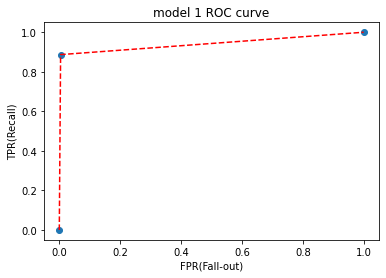

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

# roc_curve 그래프 그리기
fpr, tpr, thresholds = roc_curve(labels, test_ans)

roc = pd.DataFrame({'FPR(Fall-out)': fpr, 'TPRate(Recall)': tpr, 'Threshold': thresholds})

plt.scatter(fpr, tpr)
plt.title('model 1 ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');
plt.plot(fpr, tpr, 'r--')

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# 최적의 threshold
#print('idx:',optimal_idx, 'threshold:', optimal_threshold)

# AUC 면적 구하기
auc_score = roc_auc_score(labels, test_ans)
print('AUC:',round(auc_score,6))